# Timing Notebook

In [1]:
# Import the usual libraries
%pylab
%matplotlib inline
import os
plt.style.use('PUBstyle')
# Import sarkas
from sarkas.processes import Simulation, PostProcess, PreProcess
from sarkas.tools.transport import TransportCoefficient
from scipy.optimize import curve_fit


# Create the file path to the YAML input file
example_directory = os.path.join('..',
                                 os.path.join('sarkas',
                                              os.path.join('examples', 'Timing')))

input_file_names = [
    'ocp_N10k.yaml',
    'ocp_N20k.yaml',
    'ocp_N50k.yaml',
    'ocp_N100k.yaml',
    'ocp_N200k.yaml',
    'ocp_N500k.yaml',
    'ocp_N1000k.yaml',
] 

ptcls_num = np.array([10000, 20000, 50000, 100000, 200000, 500000, 1000000])
mean_pp_times = np.zeros(len(input_file_names) )
mean_pm_times = np.zeros(len(input_file_names) )
std_pp_times = np.zeros(len(input_file_names) )
std_pm_times = np.zeros(len(input_file_names) )



Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [ ]:
for i, fname in enumerate(input_file_names):
    inp = os.path.join(example_directory, fname)

    preproc = PreProcess(inp)
    preproc.setup(read_yaml=True)
    preproc.run(
#          timing=False, # time estimation, default is True
#          loops = 10,   # the number of timesteps to average, Default is 10
         pppm_estimate=True,
#         timing_study = True,
#         postprocessing=True,
        remove = True, # Save some space.
               )
#     print("{}".format(preproc.parameters.box_lengths[0]/preproc.potential.rc) )
    ptcls_num[i] = preproc.parameters.total_num_ptcls
    mean_pp_times[i] = np.mean(preproc.pp_acc_time[1:])
    std_pp_times[i] = np.std(preproc.pp_acc_time[1:])
    mean_pm_times[i] = np.mean(preproc.pm_acc_time[1:])
    std_pm_times[i] = np.std(preproc.pm_acc_time[1:])
    
    print('Mean PP Times: {:.6e}'.format(mean_pp_times[i]) )
    print('Mean PM Times: {:.6e}'.format(mean_pm_times[i]) )
    print(fname, ' Done')


Figures can be found in Simulations/ocp_n10k_slow/PreProcessing/PPPM_Plots/Mesh_32/Cells_5
Mean PP Times: 5.260791e+10
Mean PM Times: 3.284371e+10
ocp_N10k.yaml  Done

Figures can be found in Simulations/ocp_n20k_slow/PreProcessing/PPPM_Plots/Mesh_32/Cells_7
Mean PP Times: 7.673028e+10
Mean PM Times: 6.353055e+10
ocp_N20k.yaml  Done

Figures can be found in Simulations/ocp_n50k_slow/PreProcessing/PPPM_Plots/Mesh_32/Cells_9
Mean PP Times: 2.315224e+11
Mean PM Times: 1.639879e+11
ocp_N50k.yaml  Done

Figures can be found in Simulations/ocp_n100k_slow/PreProcessing/PPPM_Plots/Mesh_32/Cells_11
Mean PP Times: 4.717860e+11
Mean PM Times: 3.284689e+11
ocp_N100k.yaml  Done


[None, None, Text(0.5, 0, '$N$ = Number of particles')]

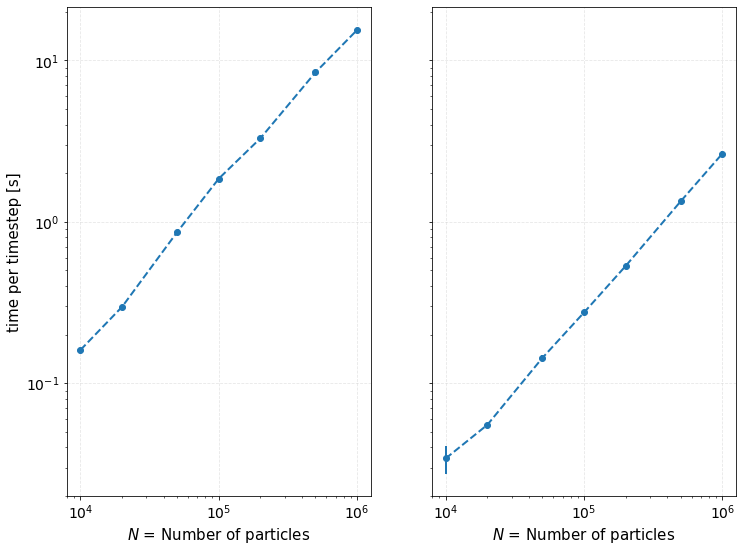

In [3]:
fig, ax = plt.subplots(1,2, figsize = (12,9), sharey = True)
ax[0].errorbar(ptcls_num, mean_pp_times*1e-9, yerr = std_pp_times*1e-9, fmt = '--o')
# ax[0].fill_between(ptcls_num, 
#                    mean_pp_times - std_pp_times,
#                   mean_pp_times + std_pp_times, alpha = 0.2)

ax[1].errorbar(ptcls_num, mean_pm_times*1e-9, yerr = std_pm_times*1e-9, fmt = '--o')
# ax[1].fill_between(ptcls_num, 
#                    mean_pm_times - std_pm_times,
#                   mean_pm_times + std_pm_times, alpha = 0.2)
ax[0].set(yscale = 'log', xscale='log', ylabel = r'time per timestep [s]', xlabel = r'$N$ = Number of particles')
ax[1].set(yscale = 'log', xscale='log', xlabel = r'$N$ = Number of particles')

In [11]:

popt, _ = curve_fit(lambda x, a, b: a * x**b,
                   ptcls_num, 
                    mean_pp_times,
                    p0 = [1e9, 1.0]
                   )
print(*popt, preproc.parameters.pppm_pp_err)

41870.487409175206 0.9283266529855201 1.8960964315722335e-06


[None, Text(0.5, 0, '$N$ = Number of particles')]

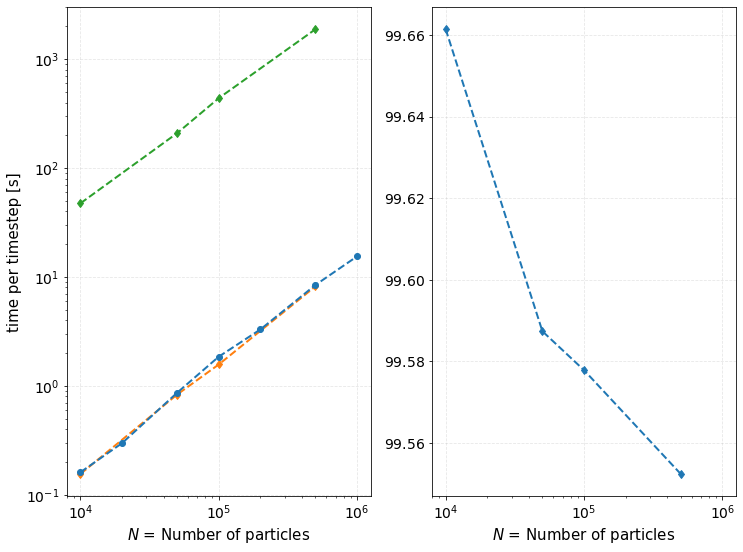

In [12]:
fig, ax = plt.subplots(1,2, figsize = (12,9), sharex = True)
ax[0].errorbar(ptcls_num, mean_pp_times*1e-9, yerr = std_pp_times*1e-9, fmt = '--o')
# ax[1].errorbar(ptcls_num, mean_pm_times*1e-9, yerr = std_pm_times*1e-9, fmt = '--o')
ax[0].plot(data["Particles"], data["Numba Mean PP Times"]*1e-9, '--d')
ax[0].plot(data["Particles"], data["Python Mean PP Times"]*1e-9, '--d')
speeds = abs(np.array([
    mean_pp_times[0],mean_pp_times[2],mean_pp_times[3],mean_pp_times[5]]) - data["Python Mean PP Times"])*100/data["Python Mean PP Times"]
ax[1].plot(data["Particles"], speeds, '--d')
# ax[0].plot(ptcls_num, popt[0]*ptcls_num**popt[1] * 1e-9, label = 'Fit')
ax[0].set(yscale = 'log', xscale='log', ylabel = r'time per timestep [s]', xlabel = r'$N$ = Number of particles')
ax[1].set(xscale='log', xlabel = r'$N$ = Number of particles')

In [13]:

import pandas as pd

data = pd.DataFrame( 
    np.stack( (ptcls_num, mean_pp_times, std_pp_times, mean_pm_times ,std_pm_times) , axis = 1),
    columns = ['Particles',
               'Numba Mean PP Times', 
               'Numba Std PP Times',
               'Numba Mean PM Times',
               'Numba Std PM Times'] )
data.to_csv('Numba_timing.csv', index = False)

In [8]:
data = pd.read_csv('Timing_Data.csv', index_col=False)

In [8]:
numbas = pd.read_csv('Numba_timing.csv', index_col=False)


In [11]:
data

,Python Mean PP Times,Python Std PP Times,Python Mean PM Times,Python Std PM Times
0,4.746795e+10,5.946179e+08,2.780403e+10,5.905404e+08
1,2.093764e+11,1.216310e+09,1.367559e+11,1.056775e+09
2,4.390014e+11,1.687709e+09,2.726222e+11,1.110827e+09
3,1.886835e+12,1.176304e+10,1.402024e+12,1.525426e+10


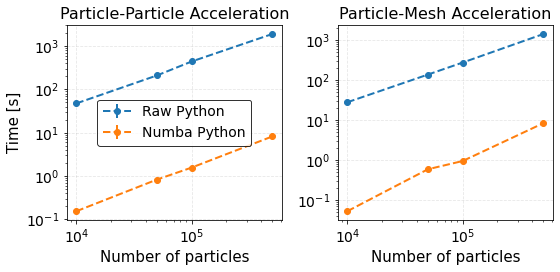

In [12]:
fig, ax = plt.subplots(1,2, figsize = (8,4), sharex = True)
ax[0].errorbar(ptcls_num, 
               data['Python Mean PP Times']*1e-9, 
               yerr = data['Python Std PP Times']*1e-9, fmt = '--o', label = 'Raw Python')
ax[0].errorbar(ptcls_num, numbas["Numba Mean PP Times"]*1e-9, 
               yerr = numbas["Numba Std PP Times"]*1e-9, fmt = '--o', label = 'Numba Python')

# ax[0].fill_between(ptcls_num, 
#                    mean_pp_times - std_pp_times,
#                   mean_pp_times + std_pp_times)

ax[1].errorbar(ptcls_num, 
               data['Python Mean PM Times']*1e-9, 
               yerr = data['Python Std PM Times']*1e-9, fmt = '--o', label = 'Raw Python')
ax[1].errorbar(ptcls_num, numbas["Numba Mean PM Times"]*1e-9, yerr = numbas["Numba Std PM Times"]*1e-9,
               fmt = '--o', label = 'Numba Python')
# ax[1].fill_between(ptcls_num, 
#                    mean_pm_times - std_pm_times,
#                   mean_pm_times + std_pm_times)
ax[0].set(title = 'Particle-Particle Acceleration', yscale = 'log', xscale='log', ylabel = r'Time [s]', xlabel = r'Number of particles')
ax[1].set(title = 'Particle-Mesh Acceleration', yscale = 'log', xscale='log', xlabel = r'Number of particles')
ax[0].legend()
# ax[1].legend()
fig.tight_layout()
fig.savefig('Timing.pdf')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (8,4), sharex = True)
ax[0].plot(ptcls_num, data["Python Mean PP Times"]/numbas["Numba Mean PP Times"], '--o')

ax[1].plot(ptcls_num, data["Python Mean PM Times"]/numbas["Numba Mean PM Times"], '--o')
ax[0].set(title = 'Particle-Particle Acceleration', xscale='log', ylabel = r'Speed up [x times]', xlabel = r'Number of particles')
ax[1].set(title = 'Particle-Mesh Acceleration',  xscale='log', xlabel = r'Number of particles')
fig.tight_layout()
fig.savefig('Speed_up.pdf')

In [ ]:
data2 = pd.DataFrame()
data2["Particles"] = ptcls_num
data2 = pd.concat([data2, numbas, data], axis = 1)

In [ ]:
data2 = pd.read_csv('Timing_Data.csv', index_col = False, encoding = 'utf-8')

In [ ]:
data2["Numba Std PM Times"]/data2["Numba Mean PM Times"]*100

In [ ]:
data2["Python Std PP Times"]/data2["Python Mean PP Times"]*100

In [ ]:
data2["Python Std PM Times"]/data2["Python Mean PM Times"]*100

In [ ]:
ptcls_num/(3.299463e-08**3)